# About

In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](pic/pid.jpg)

You task is to identify a particle type using the responses in the detector systems.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils
import pickle
import time

# Download data

Download data used to train classifiers.

### Read training file

In [4]:
data = pandas.read_csv('training.csv.gz')

In [5]:
data.head()

TrackP  TrackNDoFSubdetector2  BremDLLbeElectron  MuonLooseFlag  \
0  74791.156263                   15.0           0.232275            1.0   
1   2738.489989                   15.0          -0.357748            0.0   
2   2161.409908                   17.0        -999.000000            0.0   
3  15277.730490                   20.0          -0.638984            0.0   
4   7563.700195                   19.0          -0.638962            0.0   

   FlagSpd   SpdE  EcalDLLbeElectron     DLLmuon  RICHpFlagElectron  \
0      1.0    3.2          -2.505719    6.604153                1.0   
1      1.0    3.2           1.864351    0.263651                1.0   
2      0.0 -999.0        -999.000000 -999.000000                0.0   
3      1.0    3.2          -2.533918   -8.724949                1.0   
4      1.0    3.2          -2.087146   -7.060422                1.0   

   EcalDLLbeMuon        ...         TrackNDoF  RICHpFlagMuon  RICH_DLLbeKaon  \
0       1.929960        ...              28.0            1.0       -7.213300   
1      -2.061959        ...              32.0            1.0       -0.324317   
2    -999.000000        ...              27.0            0.0     -999.000000   
3      -3.253981        ...              36.0            1.0      -35.202221   
4      -0.995816        ...              33.0            1.0       25.084287   

   RICH_DLLbeElectron        HcalE  MuonFlag  FlagMuon        PrsE  \
0           -0.280200  5586.589846       1.0       1.0   10.422315   
1            1.707283    -0.000007       0.0       1.0   43.334935   
2         -999.000000  -999.000000       0.0       0.0 -999.000000   
3          -14.742319  4482.803707       0.0       1.0    2.194175   
4          -10.272412  5107.554680       0.0       1.0    0.000015   

   RICH_DLLbeMuon  RICH_DLLbeProton  
0   -2.081143e-07        -24.824400  
1    2.771583e+00         -0.648017  
2   -9.990000e+02       -999.000000  
3   -3.070819e+00        -29.291519  
4   -5.373712e+00         23.653087  

[5 rows x 50 columns]

### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

 | ID | id value for tracks (presents only in the test file for the submitting purposes)|
 | -: |:---: |
 | Label | string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.|
 | FlagSpd | flag (0 or 1), if reconstructed track passes through Spd|
 | FlagPrs | flag (0 or 1), if reconstructed track passes through Prs|
 | FlagBrem | flag (0 or 1), if reconstructed track passes through Brem|
 | FlagEcal | flag (0 or 1), if reconstructed track passes through Ecal|
 | FlagHcal | flag (0 or 1), if reconstructed track passes through Hcal|
 | FlagRICH1 | flag (0 or 1), if reconstructed track passes through the first RICH detector|
 | FlagRICH2 | flag (0 or 1), if reconstructed track passes through the second RICH detector|
 | FlagMuon | flag (0 or 1), if reconstructed track passes through muon stations (Muon)|
 | SpdE | energy deposit associated to the track in the Spd|
 | PrsE | energy deposit associated to the track in the Prs|
 | EcalE | energy deposit associated to the track in the Hcal|
 | HcalE | energy deposit associated to the track in the Hcal|
 | PrsDLLbeElectron | delta log-likelihood for a particle candidate to be electron using information from Prs|
 | BremDLLbeElectron | delta log-likelihood for a particle candidate to be electron using information from Brem|
 | TrackP | particle momentum|
 | TrackPt | particle transverse momentum|
 | TrackNDoFSubdetector1 |- number of degrees of freedom for track fit using hits in the tracking sub-detector1|
 | TrackQualitySubdetector1 | chi2 quality of the track fit using hits in the tracking sub-detector1|
 | TrackNDoFSubdetector2 | number of degrees of freedom for track fit using hits in the tracking sub-detector2|
 | TrackQualitySubdetector2 | chi2 quality of the track fit using hits in the  tracking sub-detector2|
 | TrackNDoF | number of degrees of freedom for track fit using hits in all tracking sub-detectors|
 | TrackQualityPerNDoF | chi2 quality of the track fit per degree of freedom|
 | TrackDistanceToZ | distance between track and z-axis (beam axis)|
 | Calo2dFitQuality | quality of the 2d fit of the clusters in the calorimeter |
 | Calo3dFitQuality | quality of the 3d fit in the calorimeter with assumption that particle was electron|
 | EcalDLLbeElectron | delta log-likelihood for a particle candidate to be electron using information from Ecal|
 | EcalDLLbeMuon | delta log-likelihood for a particle candidate to be muon using information from Ecal|
 | EcalShowerLongitudinalParameter | longitudinal parameter of Ecal shower|
 | HcalDLLbeElectron | delta log-likelihood for a particle candidate to be electron using information from Hcal|
 | HcalDLLbeMuon | delta log-likelihood for a particle candidate to be using information from Hcal|
 | RICHpFlagElectron | flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light|
 | RICHpFlagProton | flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light|
 | RICHpFlagPion | flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light|
 | RICHpFlagKaon | flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light|
 | RICHpFlagMuon | flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light|
 | RICH_DLLbeBCK |- delta log-likelihood for a particle candidate to be background using information from RICH|
 | RICH_DLLbeKaon | delta log-likelihood for a particle candidate to be kaon using information from RICH|
 | RICH_DLLbeElectron | delta log-likelihood for a particle candidate to be electron using information from RICH|
 | RICH_DLLbeMuon | delta log-likelihood for a particle candidate to be muon using information from RICH|
 | RICH_DLLbeProton | delta log-likelihood for a particle candidate to be proton using information from RICH|
 | MuonFlag | muon flag (is this track muon) which is determined from muon stations|
 | MuonLooseFlag |uon flag (is this track muon) which is determined from muon stations using looser criteria|
 | MuonLLbeBCK | log-likelihood for a particle candidate to be not muon using information from muon stations|
 | MuonLLbeMuon | log-likelihood for a particle candidate to be muon using information from muon stations|
 | DLLelectron | delta log-likelihood for a particle candidate to be electron using information from all subdetectors|
 | DLLmuon | delta log-likelihood for a particle candidate to be muon using information from all subdetectors|
 | DLLkaon | delta log-likelihood for a particle candidate to be kaon using information from all subdetectors|
 | DLLproton | delta log-likelihood for a particle candidate to be proton using information from all subdetectors|
 | GhostProbability | probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.|

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### Look at the labels set

The training data contains six classes. Each class corresponds to a particle type. Your task is to predict type of a particle.

In [6]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Convert the particle types into class numbers.

In [7]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Define training features

The following set of features describe particle responses in the detector systems:

![features](pic/features.jpeg)

Also there are several combined features. The full list is following.

In [14]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['HcalDLLbeMuon',
 'TrackNDoF',
 'TrackP',
 'DLLelectron',
 'BremDLLbeElectron',
 'MuonLooseFlag',
 'TrackPt',
 'PrsE',
 'RICH_DLLbeElectron',
 'MuonLLbeBCK',
 'EcalDLLbeElectron',
 'TrackNDoFSubdetector1',
 'EcalShowerLongitudinalParameter',
 'HcalDLLbeElectron',
 'TrackNDoFSubdetector2',
 'RICHpFlagElectron',
 'MuonFlag',
 'FlagMuon',
 'FlagRICH1',
 'RICHpFlagMuon',
 'RICH_DLLbeMuon',
 'PrsDLLbeElectron',
 'FlagPrs',
 'FlagEcal',
 'HcalE',
 'FlagSpd',
 'EcalDLLbeMuon',
 'FlagBrem',
 'FlagRICH2',
 'Calo3dFitQuality',
 'DLLkaon',
 'RICH_DLLbeBCK',
 'MuonLLbeMuon',
 'RICHpFlagKaon',
 'SpdE',
 'TrackQualitySubdetector2',
 'EcalE',
 'FlagHcal',
 'RICH_DLLbeProton',
 'TrackDistanceToZ',
 'RICHpFlagPion',
 'DLLproton',
 'DLLmuon',
 'GhostProbability',
 'RICHpFlagProton',
 'RICH_DLLbeKaon',
 'TrackQualitySubdetector1',
 'Calo2dFitQuality',
 'TrackQualityPerNDoF']

### Divide training data into 2 parts

In [8]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.050)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
len(training_data), len(validation_data)

(60000, 1140000)

# Sklearn classifier

On this step your task is to train **Sklearn** classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
%%time 
if 0:
    # gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.3, random_state=13,
    #                                 min_samples_leaf=100, max_depth=3)

    gb = GradientBoostingClassifier(learning_rate=0.1/2, n_estimators=500, subsample=0.3, random_state=13,
                                     min_samples_leaf=100, max_depth=4)

    gb.fit(training_data[features].values, training_data.Class.values)
    print('Train done')

    proba_gb = gb.predict_proba(validation_data[features].values)
    L=log_loss(validation_data.Class.values, proba_gb)
    print(L)


Wall time: 0 ns


## Steroid gradient boosting

In [ ]:
%%time 
from xgboost import XGBClassifier
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.8)
X_train=training_data[features].values;
y_train=training_data.Class.values;
val_loss_list=[]

est_vec = [x * 100 for x in [15]]
for n_estim in est_vec:
    t = time.time()
    xgb = XGBClassifier(base_score=0.5,
                        booster='gbtree',
                        colsample_bylevel=1,
                        colsample_bytree=1,
                        gamma=0,
                        learning_rate=1/20, 
                        max_delta_step=0,
                        max_depth=5,
                        min_child_weight=1,
                        missing=None,
                        n_estimators=n_estim,
                        n_jobs=-1,
                        nthread=None,
                        objective='multi:softprob',
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=1, 
                        seed   = None,
                        silent = False, 
                        subsample =1,
                        updater='grow_gpu')
    print( "Start with %d estimators.\n" % n_estim )
    xgb.fit(X_train, y_train)
    elapsed = time.time() - t
    print( "Fit time: %f seconds.\n" %elapsed )
    
    proba_xgb = xgb.predict_proba(validation_data[features].values)
    L=log_loss(validation_data.Class.values, proba_xgb)
    val_loss_list.append(L)
    print(L)
    
    pickle.dump(xgb, open( ("xgboost_estim_%d.pickle.dat"%n_estim), "wb"))

plt.plot(est_vec, val_loss_list)
plt.title('A simple chirp')
plt.show()
print(val_loss_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Start with 1500 estimators.



In [25]:
est_vec = [x * 100 for x in [15]]
est_vec

[1500]

### Log loss on the cross validation sample

ValueError: x and y must have same first dimension, but have shapes (5,) and (3,)

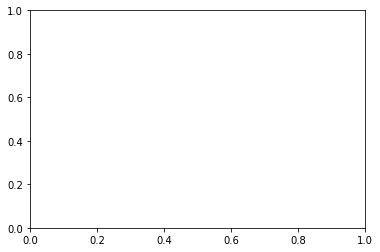

In [33]:
plt.plot(est_vec, val_loss_list)
plt.title('A simple chirp')
plt.show()
print(val_loss_list)

# Keras neural network

On this step your task is to train **Keras** NN classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can. Data preprocessing may help you to improve your score.

In [ ]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

In [ ]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))
    model.add(Dense(200))
    model.add(Activation('tanh'))
    model.add(Dense(100))
    model.add(Activation('tanh'))
    model.add(Dense(50))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [ ]:
nn = nn_model(len(features))
nn.fit(training_data[features].values, np_utils.to_categorical(training_data.Class.values), verbose=1, nb_epoch=50, batch_size=256)

### Log loss on the cross validation sample

In [ ]:
# predict each track
proba_nn = nn.predict_proba(validation_data[features].values)

In [ ]:
log_loss(validation_data.Class.values, proba_nn)

# Quality metrics

Plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [ ]:
proba = proba_gb

In [ ]:
utils.plot_roc_curves(proba, validation_data.Class.values)

In [ ]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

In [ ]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Prepare submission

Select your best classifier and prepare submission file.

In [19]:
test = pandas.read_csv('test.csv.gz')

In [20]:
# xgb = pickle.load( open( "xgboost_estim_1500.pickle.dat", "rb" ) )
best_model = xgb

In [21]:
# predict test sample
# submit_proba = best_model.predict_proba(test[features])
submit_proba = best_model.predict_proba(test[features].values)
submit_ids = test.ID

In [22]:
from IPython.display import FileLink
utils.create_solution(submit_ids, submit_proba, filename='submission_file.csv.gz')

D:\courses\hadron-collider-machine-learning\week2\submission_file.csv.gz